In [34]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import SGD #gradient descent optimizer

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression as logit
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from imblearn.over_sampling import SMOTE #with 1.2.2 scikit

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGBC
from xgboost import plot_importance

In [2]:
aki_df = pd.read_csv("sph6004_assignment1_data_nareplaced.csv",index_col=False)

In [3]:
aki_df

id  aki_key  aki  gender_key  admission_age  Race key  \
0      38257855        1    3           2      73.936365         2   
1      36408389        1    1           2      52.977503         2   
2      36334808        1    3           2      52.787621         2   
3      32307091        1    3           2      75.699091         2   
4      34710115        0    0           1      40.331739         2   
...         ...      ...  ...         ...            ...       ...   
50915  32805551        1    1           2      41.845446         5   
50916  33682695        0    0           1      71.149096         5   
50917  32535084        0    0           2      82.481830         2   
50918  39960907        1    2           1      53.660331         5   
50919  30632197        1    2           2      53.288123         1   

       heart_rate_min  heart_rate_max  heart_rate_mean  sbp_min  ...  \
0                47.0            66.0        56.650000     90.0  ...   
1                69.0            95.0        79.176471     80.0  ...   
2                63.0            89.0        75.370370     96.0  ...   
3                69.0            94.0        79.960000     82.0  ...   
4                95.0           137.0       116.368421     91.0  ...   
...               ...             ...              ...      ...  ...   
50915            55.0           113.0        68.878049     87.0  ...   
50916            74.0           132.0        96.708333    109.0  ...   
50917            91.0           117.0       100.166667    110.0  ...   
50918            44.0            92.0        55.807692     88.0  ...   
50919            56.0           116.0        79.321429     79.0  ...   

          ggt_max  ld_ldh_min  ld_ldh_max  gcs_min  gcs_motor  gcs_verbal  \
0      155.271186  470.911158  582.595411     15.0        6.0         5.0   
1      155.271186  210.000000  210.000000     15.0        6.0         5.0   
2      155.271186  470.911158  582.595411     14.0        6.0         5.0   
3      155.271186  470.911158  582.595411     14.0        6.0         5.0   
4      155.271186  470.911158  582.595411     15.0        6.0         5.0   
...           ...         ...         ...      ...        ...         ...   
50915  155.271186  365.000000  365.000000     14.0        6.0         5.0   
50916  155.271186  470.911158  582.595411      3.0        1.0         1.0   
50917  155.271186  470.911158  582.595411     15.0        6.0         5.0   
50918  155.271186  470.911158  582.595411     15.0        6.0         5.0   
50919  155.271186  162.000000  162.000000     15.0        1.0         0.0   

       gcs_eyes  gcs_unable      height  weight_admit  
0           4.0         0.0  169.628199          81.4  
1           4.0         0.0  169.628199        1251.0  
2           3.0         0.0  169.628199        1120.0  
3           3.0         0.0  169.628199        1010.0  
4           4.0         0.0  170.000000         769.7  
...         ...         ...         ...           ...  
50915       3.0         0.0  163.000000           1.0  
50916       1.0         0.0  169.628199           1.0  
50917       4.0         0.0  169.628199           1.0  
50918       4.0         0.0  202.000000           1.0  
50919       1.0         1.0  157.000000           1.0  

[50920 rows x 163 columns]

In [4]:
aki_X_raw = aki_df.iloc[:,3:]

In [5]:
aki_X_raw

gender_key  admission_age  Race key  heart_rate_min  heart_rate_max  \
0               2      73.936365         2            47.0            66.0   
1               2      52.977503         2            69.0            95.0   
2               2      52.787621         2            63.0            89.0   
3               2      75.699091         2            69.0            94.0   
4               1      40.331739         2            95.0           137.0   
...           ...            ...       ...             ...             ...   
50915           2      41.845446         5            55.0           113.0   
50916           1      71.149096         5            74.0           132.0   
50917           2      82.481830         2            91.0           117.0   
50918           1      53.660331         5            44.0            92.0   
50919           2      53.288123         1            56.0           116.0   

       heart_rate_mean  sbp_min  sbp_max    sbp_mean  dbp_min  ...  \
0            56.650000     90.0    141.5  117.648148     48.0  ...   
1            79.176471     80.0    145.0  122.785714     46.0  ...   
2            75.370370     96.0    157.0  131.576923     56.0  ...   
3            79.960000     82.0    109.0   94.920000     45.0  ...   
4           116.368421     91.0    137.0  112.666667     53.0  ...   
...                ...      ...      ...         ...      ...  ...   
50915        68.878049     87.0    169.0  127.404762     48.0  ...   
50916        96.708333    109.0    134.0  124.200000     49.0  ...   
50917       100.166667    110.0    156.0  131.583333     54.0  ...   
50918        55.807692     88.0    213.0  145.160000     57.0  ...   
50919        79.321429     79.0    201.0  119.680000     46.0  ...   

          ggt_max  ld_ldh_min  ld_ldh_max  gcs_min  gcs_motor  gcs_verbal  \
0      155.271186  470.911158  582.595411     15.0        6.0         5.0   
1      155.271186  210.000000  210.000000     15.0        6.0         5.0   
2      155.271186  470.911158  582.595411     14.0        6.0         5.0   
3      155.271186  470.911158  582.595411     14.0        6.0         5.0   
4      155.271186  470.911158  582.595411     15.0        6.0         5.0   
...           ...         ...         ...      ...        ...         ...   
50915  155.271186  365.000000  365.000000     14.0        6.0         5.0   
50916  155.271186  470.911158  582.595411      3.0        1.0         1.0   
50917  155.271186  470.911158  582.595411     15.0        6.0         5.0   
50918  155.271186  470.911158  582.595411     15.0        6.0         5.0   
50919  155.271186  162.000000  162.000000     15.0        1.0         0.0   

       gcs_eyes  gcs_unable      height  weight_admit  
0           4.0         0.0  169.628199          81.4  
1           4.0         0.0  169.628199        1251.0  
2           3.0         0.0  169.628199        1120.0  
3           3.0         0.0  169.628199        1010.0  
4           4.0         0.0  170.000000         769.7  
...         ...         ...         ...           ...  
50915       3.0         0.0  163.000000           1.0  
50916       1.0         0.0  169.628199           1.0  
50917       4.0         0.0  169.628199           1.0  
50918       4.0         0.0  202.000000           1.0  
50919       1.0         1.0  157.000000           1.0  

[50920 rows x 160 columns]

In [6]:
aki_y_df = aki_df["aki_key"]
aki_y_df

0        1
1        1
2        1
3        1
4        0
        ..
50915    1
50916    0
50917    0
50918    1
50919    1
Name: aki_key, Length: 50920, dtype: int64

In [7]:
aki_X_df = (aki_X_raw-aki_X_raw.mean())/aki_X_raw.std()
aki_X_df.describe().transpose()

count          mean  std       min           25%  \
gender_key      50920.0  3.125718e-17  1.0 -0.889056 -8.890560e-01   
admission_age   50920.0  5.269068e-16  1.0 -2.716678 -6.041188e-01   
Race key        50920.0 -1.727517e-16  1.0 -1.230151 -4.248222e-01   
heart_rate_min  50920.0 -5.273254e-16  1.0 -4.538547 -6.369122e-01   
heart_rate_max  50920.0 -4.850445e-16  1.0 -3.249129 -7.082637e-01   
...                 ...           ...  ...       ...           ...   
gcs_verbal      50920.0  1.663329e-16  1.0 -1.627561 -1.146755e+00   
gcs_eyes        50920.0  3.861099e-16  1.0 -1.927275 -1.129172e-01   
gcs_unable      50920.0  4.297863e-17  1.0 -0.509975 -5.099750e-01   
height          50920.0 -3.719605e-15  1.0 -6.360842  4.899323e-10   
weight_admit    50920.0 -3.036412e-16  1.0 -3.209404 -6.155146e-01   

                         50%       75%        max  
gender_key     -8.890560e-01  1.124767   1.124767  
admission_age   1.025176e-01  0.764503   2.194873  
Race key       -4.248222e-01 -0.424822   1.991165  
heart_rate_min -1.166943e-01  0.598605   6.321002  
heart_rate_max -1.219103e-01  0.562169   8.673392  
...                      ...       ...        ...  
gcs_verbal      7.764709e-01  0.776471   0.776471  
gcs_eyes        7.942618e-01  0.794262   0.794262  
gcs_unable     -5.099750e-01 -0.509975   1.969933  
height          4.899323e-10  0.049655   7.528568  
weight_admit   -9.673671e-02  0.453966  46.673087  

[160 rows x 8 columns]

In [8]:
aki_X_df

gender_key  admission_age  Race key  heart_rate_min  heart_rate_max  \
0        1.124767       0.520559 -0.424822       -1.482266       -1.783245   
1        1.124767      -0.692460 -0.424822       -0.051667       -0.366224   
2        1.124767      -0.703450 -0.424822       -0.441830       -0.659401   
3        1.124767       0.622579 -0.424822       -0.051667       -0.415087   
4       -0.889056      -1.424348 -0.424822        1.639041        1.686013   
...           ...            ...       ...             ...             ...   
50915    1.124767      -1.336741  1.991165       -0.962048        0.513306   
50916   -0.889056       0.359243  1.991165        0.273469        1.441699   
50917    1.124767       1.015138 -0.424822        1.378932        0.708757   
50918   -0.889056      -0.652940  1.991165       -1.677348       -0.512813   
50919    1.124767      -0.674482 -1.230151       -0.897021        0.659894   

       heart_rate_mean   sbp_min   sbp_max  sbp_mean   dbp_min  ...  \
0            -1.757423 -0.185365 -0.296479 -0.088924  0.056508  ...   
1            -0.323909 -0.755678 -0.142399  0.225119 -0.113958  ...   
2            -0.566117  0.156823  0.385873  0.762497  0.738373  ...   
3            -0.274048 -0.641615 -1.727217 -1.478222 -0.199192  ...   
4             2.042870 -0.128334 -0.494581 -0.393426  0.482674  ...   
...                ...       ...       ...       ...       ...  ...   
50915        -0.979268 -0.356459  0.914146  0.507466  0.056508  ...   
50916         0.791764  0.898230 -0.626649  0.311570  0.141741  ...   
50917         1.011841  0.955261  0.341851  0.762889  0.567907  ...   
50918        -1.811025 -0.299428  2.851145  1.592787  0.823607  ...   
50919        -0.314684 -0.812709  2.322873  0.035277 -0.113958  ...   

            ggt_max    ld_ldh_min    ld_ldh_max   gcs_min  gcs_motor  \
0     -1.347080e-11 -5.059623e-12 -1.192435e-11  0.490997   0.503182   
1     -1.347080e-11 -4.871040e-01 -4.747757e-01  0.490997   0.503182   
2     -1.347080e-11 -5.059623e-12 -1.192435e-11  0.112684   0.503182   
3     -1.347080e-11 -5.059623e-12 -1.192435e-11  0.112684   0.503182   
4     -1.347080e-11 -5.059623e-12 -1.192435e-11  0.490997   0.503182   
...             ...           ...           ...       ...        ...   
50915 -1.347080e-11 -1.977292e-01 -2.772686e-01  0.112684   0.503182   
50916 -1.347080e-11 -5.059623e-12 -1.192435e-11 -4.048761  -2.519109   
50917 -1.347080e-11 -5.059623e-12 -1.192435e-11  0.490997   0.503182   
50918 -1.347080e-11 -5.059623e-12 -1.192435e-11  0.490997   0.503182   
50919 -1.347080e-11 -5.767169e-01 -5.359392e-01  0.490997  -2.519109   

       gcs_verbal  gcs_eyes  gcs_unable        height  weight_admit  
0        0.776471  0.794262   -0.509975  4.899323e-10     -0.000962  
1        0.776471  0.794262   -0.509975  4.899323e-10     46.673087  
2        0.776471 -0.112917   -0.509975  4.899323e-10     41.445402  
3        0.776471 -0.112917   -0.509975  4.899323e-10     37.055742  
4        0.776471  0.794262   -0.509975  4.965480e-02     27.466332  
...           ...       ...         ...           ...           ...  
50915    0.776471 -0.112917   -0.509975 -8.852094e-01     -3.209404  
50916   -1.146755 -1.927275   -0.509975  4.899323e-10     -3.209404  
50917    0.776471  0.794262   -0.509975  4.899323e-10     -3.209404  
50918    0.776471  0.794262   -0.509975  4.323320e+00     -3.209404  
50919   -1.627561 -1.927275    1.969933 -1.686522e+00     -3.209404  

[50920 rows x 160 columns]

In [19]:
# We convert dataframe to PyTorch tensor datatype,
# and then split it into training and testing parts.
X = torch.tensor(aki_X_df.to_numpy(),dtype=torch.float32)
m,n = X.shape
y = torch.tensor(aki_y_df.to_numpy(),dtype=torch.float32).reshape(m,1)

# We use an approx 6:4 train test splitting
cases = ['train','test']
case_list = np.random.choice(cases,size=X.shape[0],replace=True,p=[0.8,0.2])
X_train = X[case_list=='train']
X_test = X[case_list=='test']
y_train = y[case_list=='train']
y_test = y[case_list=='test']

### Section 1a: What regularization should I use?

In [20]:
h = torch.nn.Linear(
    in_features=n,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()

# Logistic model is linear+sigmoid
f = torch.nn.Sequential(
    h,
    sigma #apply sigmoid function
)

J_BCE = torch.nn.BCELoss()
# We use the Adam optimizer, which is
# a variant of gradient descent method with momentum.
#(adapt learning rate overtime to improve stability of training and reduce time it takes) (not like the previous hands-on)
GD_optimizer = torch.optim.Adam(lr=0.005,params=f.parameters())

nIter = 5000
printInterval = 500

#same training loop with 5000 iterations
for i in range(nIter):
    GD_optimizer.zero_grad()
    pred_LR = f(X_train)
    loss = J_BCE(pred_LR,y_train)
    loss.backward()
    GD_optimizer.step()
    if i == 0 or ((i+1)%printInterval) == 0:
        print('Iter {}: average BCE loss is {:.3f}'.format(i+1,loss.item()))

with torch.no_grad():
    pred_test_LR = f(X_test)

auroc = roc_auc_score(y_test,pred_test_LR)
ap = average_precision_score(y_test,pred_test_LR)
print('On test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))
#high AUROC - model can accurately make predict the classifiers of 1 and 0 in breast cancer

Iter 1: average BCE loss is 0.732
Iter 500: average BCE loss is 0.536
Iter 1000: average BCE loss is 0.535
Iter 1500: average BCE loss is 0.535
Iter 2000: average BCE loss is 0.535
Iter 2500: average BCE loss is 0.535
Iter 3000: average BCE loss is 0.535
Iter 3500: average BCE loss is 0.535
Iter 4000: average BCE loss is 0.535
Iter 4500: average BCE loss is 0.535
Iter 5000: average BCE loss is 0.535
On test dataset: AUROC 0.769, AP 0.865


In [21]:
weight = h.weight.detach().squeeze().clone()

In [22]:
h_L2 = torch.nn.Linear(
    in_features=n,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()

f_L2 = torch.nn.Sequential(
    h_L2,
    sigma
)

J_BCE = torch.nn.BCELoss()
GD_optimizer = torch.optim.Adam(lr=0.005,params=f_L2.parameters(),weight_decay=0.1)

nIter = 500
printInterval = 50

for i in range(nIter):
    GD_optimizer.zero_grad()
    pred_LR = f_L2(X_train)
    loss = J_BCE(pred_LR,y_train)
    loss.backward()
    GD_optimizer.step()
    if i == 0 or ((i+1)%printInterval) == 0:
        print('Iter {}: average BCE loss is {:.3f}'.format(i+1,loss.item()))

with torch.no_grad():
    pred_test_LR = f_L2(X_test)

auroc = roc_auc_score(y_test,pred_test_LR)
ap = average_precision_score(y_test,pred_test_LR)
print('On test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

Iter 1: average BCE loss is 0.738
Iter 50: average BCE loss is 0.582
Iter 100: average BCE loss is 0.564
Iter 150: average BCE loss is 0.559
Iter 200: average BCE loss is 0.557
Iter 250: average BCE loss is 0.557
Iter 300: average BCE loss is 0.557
Iter 350: average BCE loss is 0.557
Iter 400: average BCE loss is 0.557
Iter 450: average BCE loss is 0.557
Iter 500: average BCE loss is 0.557
On test dataset: AUROC 0.758, AP 0.856


In [23]:
weight_L2 = h_L2.weight.detach().squeeze().clone()

In [24]:
h_L1 = torch.nn.Linear(
    in_features=n,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()

f_L1 = torch.nn.Sequential(
    h_L1,
    sigma
)

J_BCE = torch.nn.BCELoss()

GD_optimizer = torch.optim.Adam(lr=0.005,params=f_L1.parameters())

def L1_reg(model,lbd):
    result = torch.tensor(0)
    for param in model.parameters(): 
        result = result + param.abs().sum()

    return lbd*result 


nIter = 500
printInterval = 50
lbd = 0.1 

for i in range(nIter):
    GD_optimizer.zero_grad()
    pred_LR = f_L1(X_train)
    loss = J_BCE(pred_LR,y_train)
    (loss+L1_reg(f_L1,lbd)).backward()
    GD_optimizer.step()
    if i == 0 or ((i+1)%printInterval) == 0:
        print('Iter {}: average BCE loss is {:.3f}'.format(i+1,loss.item()))

with torch.no_grad():
    pred_test_LR = f_L1(X_test)

auroc = roc_auc_score(y_test,pred_test_LR)
ap = average_precision_score(y_test,pred_test_LR)
print('On test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

Iter 1: average BCE loss is 0.686
Iter 50: average BCE loss is 0.658
Iter 100: average BCE loss is 0.655
Iter 150: average BCE loss is 0.655
Iter 200: average BCE loss is 0.655
Iter 250: average BCE loss is 0.655
Iter 300: average BCE loss is 0.655
Iter 350: average BCE loss is 0.656
Iter 400: average BCE loss is 0.655
Iter 450: average BCE loss is 0.655
Iter 500: average BCE loss is 0.655
On test dataset: AUROC 0.685, AP 0.806


In [25]:
weight_L1 = h_L1.weight.detach().squeeze().clone()

In [26]:
weight_df = pd.DataFrame(
    {
        'Original':weight,
        'L2':weight_L2,
        'L1':weight_L1
    }
).melt(id_vars=[],value_vars=['Original','L2','L1'])
weight_df

variable     value
0    Original  0.014180
1    Original  0.328581
2    Original -0.022448
3    Original  0.147668
4    Original  0.143155
..        ...       ...
475        L1 -0.001694
476        L1 -0.002313
477        L1  0.000483
478        L1 -0.000040
479        L1  0.003900

[480 rows x 2 columns]

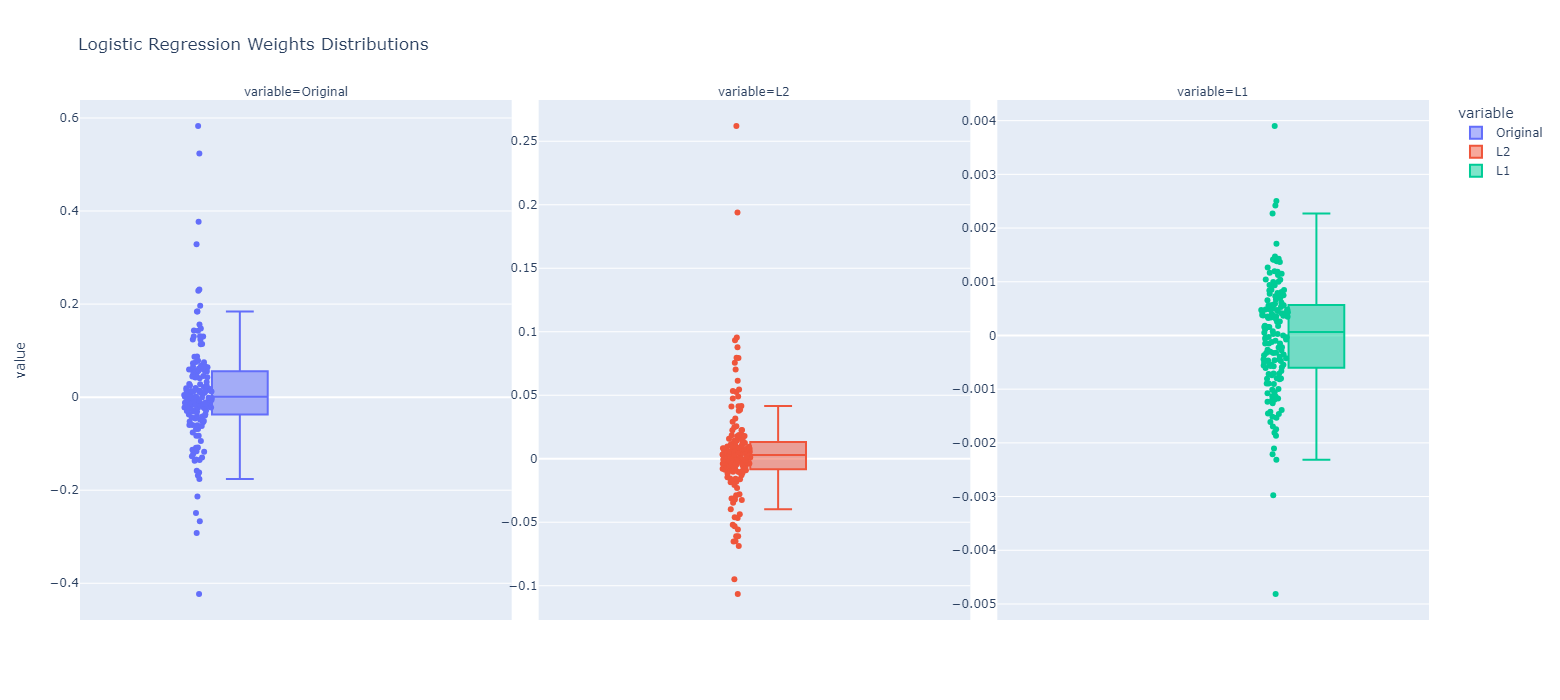

In [27]:
fig = px.box(
    weight_df,
    y='value',
    facet_col='variable',
    color='variable',
    points='all',
    title='Logistic Regression Weights Distributions'
)
fig.update_yaxes(
    matches=None,
    showticklabels=True
)
fig.update_traces(jitter=0.5)

fig.update_layout(
    autosize=False,
    width=1500,
    height=700,
)

# alot of points in L1 is near 0, so this means L1 can be used as a feature selector, can ignore unimpt ones at 0, and use the others

In [28]:
X_df_train_imb = aki_X_df.iloc[case_list=='train',:]
X_df_test_imb = aki_X_df.iloc[case_list=='test',:]
y_df_train_imb = aki_y_df.iloc[case_list=='train']
y_df_test_imb = aki_y_df.iloc[case_list=='test']

AKI - better to predict that they might have AKI than if not (pred 1 for 0) thus SMOTE better than balanced weight, vanilla has >60% (count confirm?) of false positives.

### Section 1b: So we should run L2 for the model to select for features

In [29]:
model = logit(penalty = "l2", C = 1/10,solver='liblinear')

forward_selection = SFS(
    model, n_features_to_select=5, direction="forward"
).fit(X_df_train_imb,y_df_train_imb)

In [30]:
forward_selection

SequentialFeatureSelector(estimator=LogisticRegression(C=0.1,
                                                       solver='liblinear'),
                          n_features_to_select=5)

In [31]:
forward_selection.get_feature_names_out()

array(['admission_age', 'sbp_min', 'resp_rate_max', 'bun_min',
       'gcs_verbal'], dtype=object)

In [32]:
# Full features model
model.fit(X_df_train_imb,y_df_train_imb)
y_pred_full = model.predict_proba(X_df_test_imb)

# Model with forward selected features
model.fit(forward_selection.transform(X_df_train_imb),y_df_train_imb)
y_pred_FS = model.predict_proba(forward_selection.transform(X_df_test_imb))


In [35]:
fpr_full, tpr_full, _ = roc_curve(y_df_test_imb,y_pred_full[:,1])
fpr_FS, tpr_FS, _ = roc_curve(y_df_test_imb,y_pred_FS[:,1])

In [36]:
auroc_full = roc_auc_score(y_df_test_imb,y_pred_full[:,1])
ap_full = average_precision_score(y_df_test_imb,y_pred_full[:,1])
print('Full Feature Model - On test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc_full,ap_full))

auroc_FS = roc_auc_score(y_df_test_imb,y_pred_FS[:,1])
ap_FS = average_precision_score(y_df_test_imb,y_pred_FS[:,1])
print('Forward Selection Model - On test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc_FS,ap_FS))

Full Feature Model - On test dataset: AUROC 0.769, AP 0.865
Forward Selection Model - On test dataset: AUROC 0.702, AP 0.810


In [37]:
roc_df = pd.DataFrame(
    {
        'False Positive Rate':np.hstack([fpr_full,fpr_FS]),
        'True Positive Rate':np.hstack([tpr_full,tpr_FS]),
        'method':['Full Feature Model']*len(fpr_full)+['Forward Selection']*len(fpr_FS)
    }
)

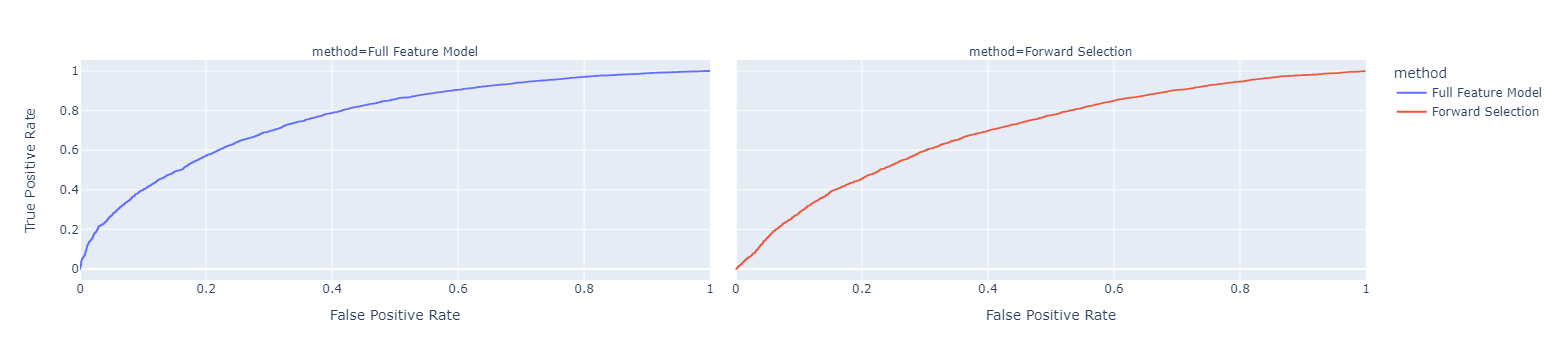

In [38]:
#AUROC Curve
fig = px.line(roc_df,y='True Positive Rate',x='False Positive Rate',facet_col='method',color='method')
fig

In [39]:
# precision recall curve
p_full, r_full, _ = precision_recall_curve(y_df_test_imb,y_pred_full[:,1])
p_FS, r_FS, _ = precision_recall_curve(y_df_test_imb,y_pred_FS[:,1])

pr_df = pd.DataFrame(
    {
        'Precision':np.hstack([p_full,p_FS]),
        'Recall':np.hstack([r_full,r_FS]),
        'method':['Full Feature Model']*len(p_full)+['Forward Selection']*len(p_FS)
    }
)

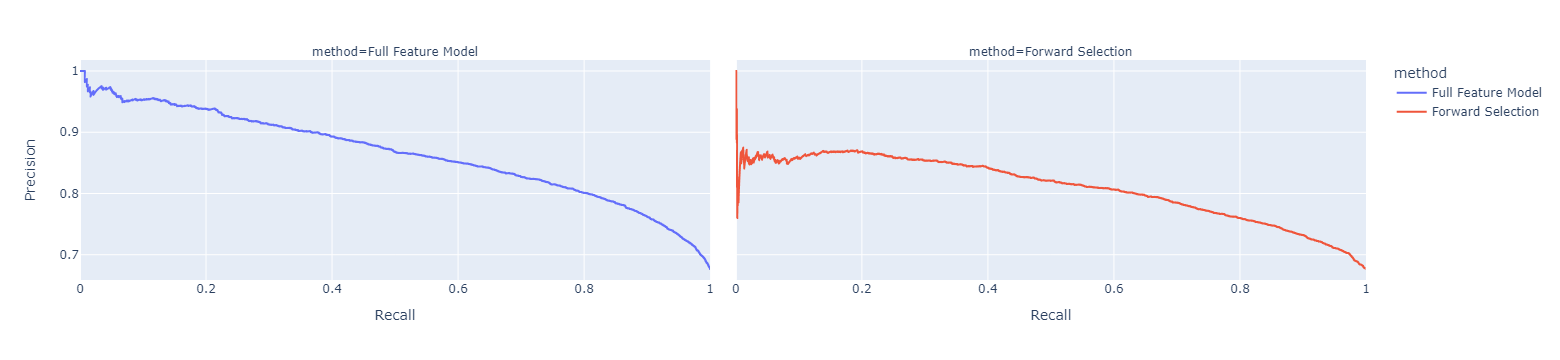

In [40]:
# Visualize precision recall curve
fig = px.line(pr_df,x='Recall',y='Precision',facet_col='method',color='method')
fig

#all very good - dont need all 30 variables to run the model and get the results you need
# sometimes you might get better results with lesser variables (due to noise from other features / correlation of features)

## Section 2

In [147]:
fs5_aki_X_df = aki_X_raw[['admission_age', 'gcs_verbal', 'resp_rate_max', 'bun_max', 'pt_max']]
fs5_Xy = pd.concat([fs5_aki_X_df,aki_y_df],axis=1)
fs5_Xy['label'] = np.where(fs5_Xy['aki_key'].to_numpy()==0,'No_AKI','AKI')
fs5_Xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50920 entries, 0 to 50919
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   admission_age  50920 non-null  float64
 1   gcs_verbal     50920 non-null  float64
 2   resp_rate_max  50920 non-null  float64
 3   bun_max        50920 non-null  float64
 4   pt_max         50920 non-null  float64
 5   aki_key        50920 non-null  int64  
 6   label          50920 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 2.7+ MB


In [148]:
fs5_Xy

admission_age  gcs_verbal  resp_rate_max  bun_max     pt_max  aki_key  \
0          73.936365         5.0           20.0      7.0  11.500000        1   
1          52.977503         5.0           23.0     10.0  13.600000        1   
2          52.787621         5.0           21.0     23.0  10.200000        1   
3          75.699091         5.0           24.0     13.0  12.900000        1   
4          40.331739         5.0           41.0     10.0  16.586131        0   
...              ...         ...            ...      ...        ...      ...   
50915      41.845446         5.0           35.0     16.0  11.600000        1   
50916      71.149096         1.0           24.0      9.0  10.100000        0   
50917      82.481830         5.0           33.0      1.0  16.586131        0   
50918      53.660331         5.0           25.0      7.0  13.100000        1   
50919      53.288123         0.0           27.0     27.0  12.400000        1   

        label  
0         AKI  
1         AKI  
2         AKI  
3         AKI  
4      No_AKI  
...       ...  
50915     AKI  
50916  No_AKI  
50917  No_AKI  
50918     AKI  
50919     AKI  

[50920 rows x 7 columns]

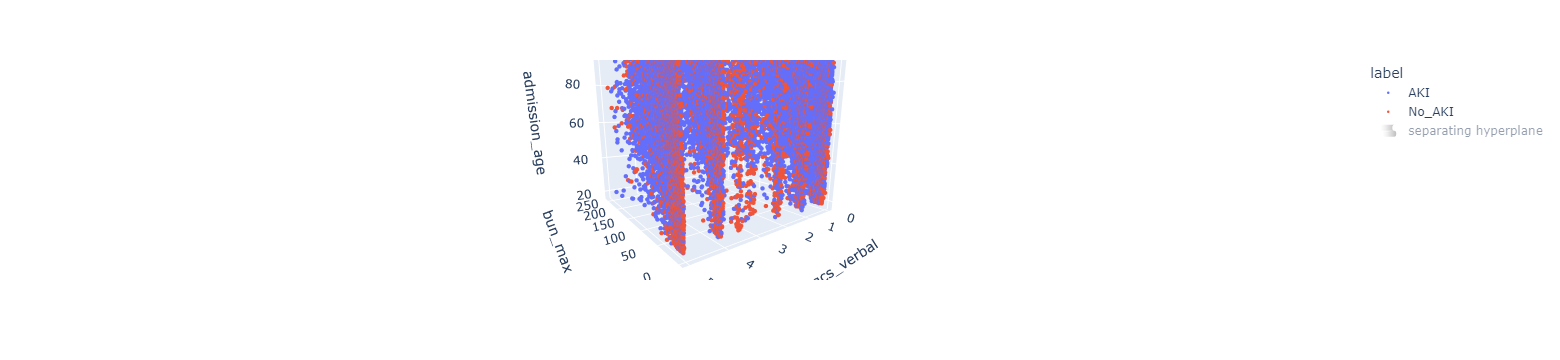

In [54]:
fig = px.scatter_3d(
    fs5_Xy,
    z='admission_age',
    y='gcs_verbal',
    x='bun_max',
    color='label'
)

fig.update_traces(
    marker={'size':2.5}
)

surface_z = [[0.052,0.052],[0.052,0.052]]
surface_y = [0.1,2.7]
surface_x = [0,0.29]

fig.add_trace(
    go.Surface(
        x=surface_x,
        y=surface_y,
        z=surface_z,
        opacity=0.5,
        showscale=False,
        colorscale='greys',
        name='separating hyperplane',
        showlegend=True,
        visible='legendonly'
    )
)

fig

In [149]:
X_df_train_fs5 = fs5_aki_X_df.iloc[case_list=='train',:]
X_df_test_fs5 = fs5_aki_X_df.iloc[case_list=='test',:]
y_df_train_fs5 = aki_y_df.iloc[case_list=='train']
y_df_test_fs5 = aki_y_df.iloc[case_list=='test']

In [150]:
# We first build a shallow decision tree. Criterion set using entropy loss
TreeModel = DTC(criterion='entropy',max_depth=1,random_state=15)
TreeModel.fit(X_df_train_fs5,y_df_train_fs5)

DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=15)

In [152]:
# The `max_depth` parameter is important for decision tree.
# We use `GridSearchCV` to select the best `max_depth`.

parameters = {'max_depth':np.arange(start=1,stop=10,step=1)}
parameters

{'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}

In [153]:
stratifiedCV = StratifiedKFold(n_splits=8) #create GridSearch object
TreeModel = DTC(criterion='entropy')
#loop through all possible max_depth value 1-9 and train on
#for eg. 7 folds of data, and test with final fold and repeat for each combo
#using each max depth value
BestTree = GridSearchCV(
    TreeModel,
    param_grid=parameters,
    scoring='roc_auc',
    cv=stratifiedCV
)
BestTree.fit(X_df_train_fs5,y_df_train_fs5)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='roc_auc')

In [154]:
BestTree.fit(X_df_train_fs5,y_df_train_fs5)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='roc_auc')

In [155]:
BestTree.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [156]:
BestTree.best_score_

0.6861725168503393

In [179]:
y_pred_dt = BestTree.predict(X_df_test_fs5)
print('AUROC score on test set: {:.4f}'.format(roc_auc_score(y_df_test_fs5,y_pred_dt)))
print('ap score on test set: {:.4f}'.format(average_precision_score(y_df_test_fs5,y_pred_dt)))
print('fscore on test set: {:.4f}'.format(f1_score(y_df_test_fs5,y_pred_dt)))
pd.crosstab(y_df_test_fs5,y_pred_dt)

AUROC score on test set: 0.6074
ap score on test set: 0.7200
fscore on test set: 0.8005


col_0       0     1
aki_key            
0        1093  2287
1         739  6070

In [158]:
TreeModel_1 = DTC(criterion='entropy',max_depth=5,random_state=15)
TreeModel_1.fit(X_df_train_fs5,y_df_train_fs5)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=15)

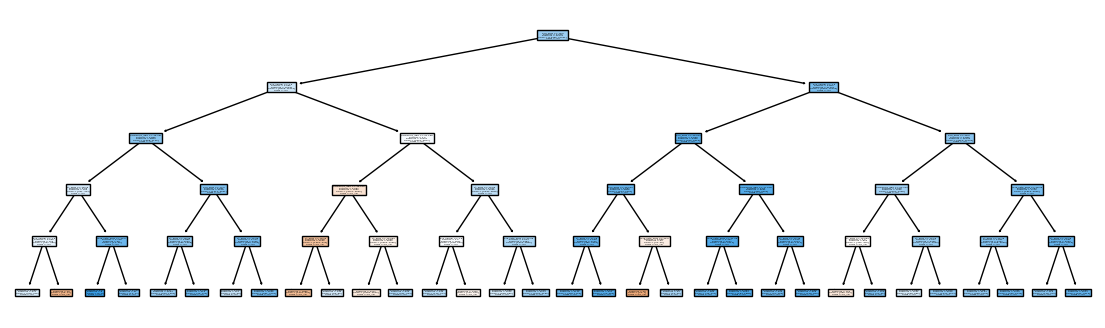

In [177]:
# Splitting rules can be visualized by using plot_tree in sklearn
plt.figure(figsize=(14,4))
plot_tree(
    TreeModel_1,
    filled=True,
    feature_names=['admission_age', 'gcs_verbal', 'resp_rate_max', 'bun_max', 'pt_max'],
    class_names=['No_AKI','AKI']
)
plt.show()


In [174]:
plt.savefig('foo.png')

<Figure size 640x480 with 0 Axes>

## XGBoost

In [160]:
parameters = {
    'n_estimators':np.arange(start=2,stop=20,step=2),
    'max_depth':np.arange(start=2,stop=6,step=1),
    'learning_rate':np.arange(start=0.05,stop=0.4,step=0.05)
}

parameters

{'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 'max_depth': array([2, 3, 4, 5]),
 'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35])}

In [161]:
stratifiedCV = StratifiedKFold(n_splits=8)
# XGBC: XGBoost classifier (C = classification, but it can also run regression)
# have to run through 8 folds of data for 252 different combination of parameters
XGBoostModel = XGBC()
BestXGBoost = GridSearchCV(
    XGBoostModel,
    param_grid=parameters,
    scoring='roc_auc',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1 # use all cpu cores to speedup grid search
)
BestXGBoost.fit(X_df_train_fs5,y_df_train_fs5)

Fitting 8 folds for each of 252 candidates, totalling 2016 fits


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
                         'max_depth': array([2, 3, 4, 5]),
                         'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
             scoring='roc_auc', verbose=1)

In [163]:
BestXGBoost.best_params_

{'learning_rate': 0.25, 'max_depth': 5, 'n_estimators': 18}

In [164]:
BestXGBoost.best_score_

0.7066128282557597

In [165]:
y_pred_xg = BestXGBoost.predict(X_df_test_fs5)
print('roc_auc_score score on test set: {:.4f}'.format(roc_auc_score(y_df_test_fs5,y_pred_xg)))
print('average_precision_score score on test set: {:.4f}'.format(average_precision_score(y_df_test_fs5,y_pred_xg)))
print('fscore score on test set: {:.4f}'.format(f1_score(y_df_test_fs5,y_pred_xg)))

pd.crosstab(y_df_test_fs5,y_pred_xg)

roc_auc_score score on test set: 0.6156
average_precision_score score on test set: 0.7243
fscore score on test set: 0.8093


col_0       0     1
aki_key            
0        1093  2287
1         627  6182

In [166]:
print(BestXGBoost.best_estimator_.feature_importances_)

[0.12332185 0.37783313 0.08977955 0.29659054 0.11247487]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

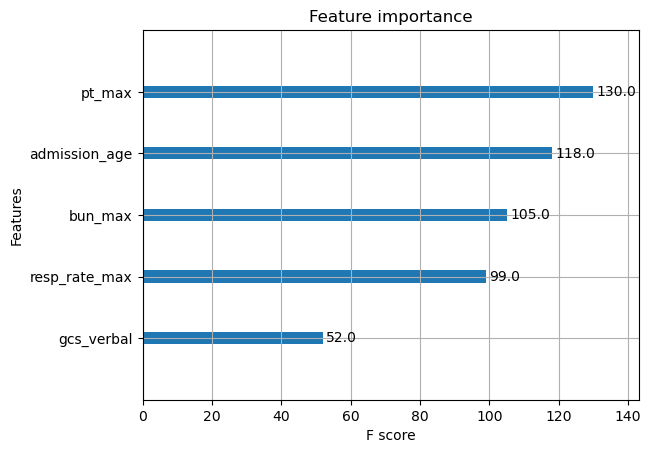

In [168]:
plot_importance(BestXGBoost.best_estimator_)

## Random Forest

In [169]:
rf = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': np.arange(start=50,stop=200,step=20),
    'max_features': ['sqrt', 'log2']
}

rand_for = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
rand_for.fit(X_df_train_fs5,y_df_train_fs5)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': array([ 50,  70,  90, 110, 130, 150, 170, 190])})

In [170]:
print(rand_for.best_params_)

{'max_features': 'sqrt', 'n_estimators': 190}


In [171]:
rand_for.best_score_

0.6865042512625015

In [172]:
y_pred_RF = rand_for.predict(X_df_test_fs5)
print('AUROC score on test set: {:.4f}'.format(roc_auc_score(y_df_test_fs5,y_pred_RF)))
print('AP score on test set: {:.4f}'.format(average_precision_score(y_df_test_fs5,y_pred_RF)))
print('fscore score on test set: {:.4f}'.format(f1_score(y_df_test_fs5,y_pred_RF)))

pd.crosstab(y_df_test_fs5,y_pred_RF)

AUROC score on test set: 0.6029
AP score on test set: 0.7179
fscore score on test set: 0.7850


col_0       0     1
aki_key            
0        1189  2191
1         994  5815